# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [3]:
import matplotlib.pyplot as plt
import random
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task


In [17]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        #return [new_thrust + random.gauss(0., 1.) for x in range(4)]
        return [new_thrust + x for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [52]:
%%time

%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 500.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 72.3 ms, sys: 12.2 ms, total: 84.6 ms
Wall time: 107 ms


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

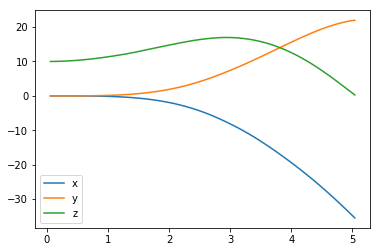

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

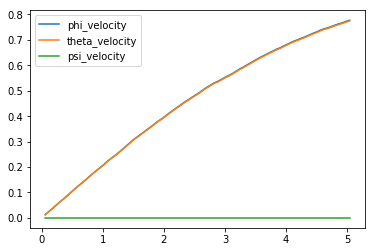

In [22]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

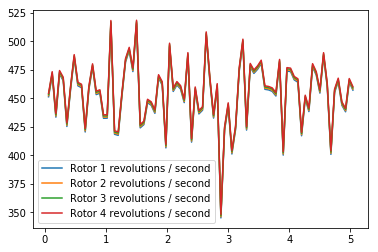

In [23]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent -- this is stochastic policy search

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

Episode = 10000, score = -481.688 (best = -352.029), noise_scale = 3 steps=23   CPU times: user 3min 34s, sys: 15.2 s, total: 3min 49s
Wall time: 3min 38s


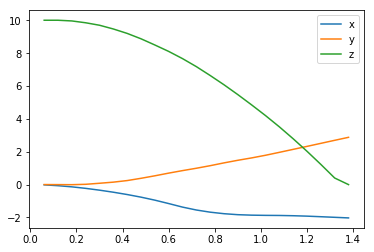

In [5]:
%%time

'''
didn't see improvment when num_episodes > 3000
linear s->a is too weak for this problem
reward doesn't make sense
'''
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 10000
target_pos = np.array([10., 10., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

score_, times_, xs_, ys_, zs_ = -np.inf, None, None, None, None

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    #print('episod ', i_episode, ' init pos: ', task.sim.pose)
    steps = 0
    times, xs, ys, zs = [], [], [], []
    while True:
        steps += 1
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        times.append(task.sim.time)
        xs.append(task.sim.pose[0])
        ys.append(task.sim.pose[1])
        zs.append(task.sim.pose[2])
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {} steps={} ".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale, steps), end="")  # [debug]
            break
    if agent.score > score_:
        score_, times_, xs_, ys_, zs_ = agent.best_score, times, xs, ys, zs

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(times, xs, label='x')
plt.plot(times, ys, label='y')
plt.plot(times, zs, label='z')
plt.legend()
_ = plt.ylim()


This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [ ]:
%%time

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import numpy as np
from task import Task
from agents import agent

max_steps=256
target_pos=np.array([0., 0., 25.])
init_pose=np.array([0., 0., 10., 0., 0., 0.])
task = Task(target_pos=target_pos, init_pose=init_pose, runtime=max_steps)

print(init_pose, '-->', target_pos)
qmaxs, xyzs = agent.main(task, epoches=20000, max_steps=max_steps)


[  0.   0.  10.   0.   0.   0.] --> [  0.   0.  25.]
replay_buffer_size, state_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, actor_tau, critic_tau, batch_size
 128000 12 4 500 0.001 0.01 1 0.9 0.9 32
------------ target pos reached.  epoch  37 step 131 (-0.34, -0.67, 24.36), angles (6.16, 0.17, 0.00)


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

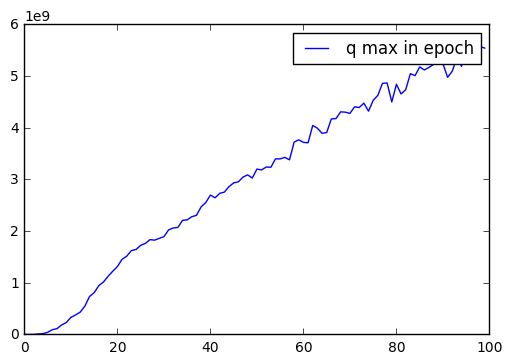

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(qmaxs, label='q max in epoch')
plt.legend()
_ = plt.ylim()

#  ; q max dropped along with epochs

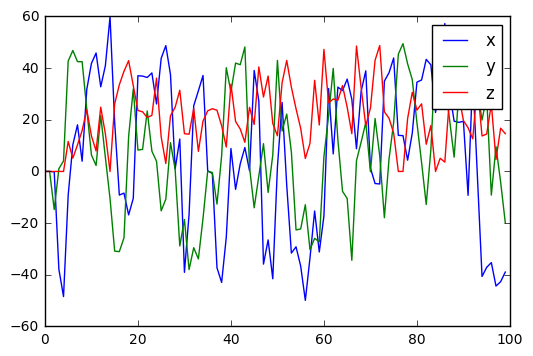

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
xs, ys, zs, _, _, _ = zip(*xyzs)
plt.plot(xs, label='x')
plt.plot(ys, label='y')
plt.plot(zs, label='z')
plt.legend()
_ = plt.ylim()

<pre>[  0.   0.  10.   0.   0.   0.] --> [  0.   0.  25.]
replay_buffer_size, state_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, actor_tau, critic_tau, batch_size
 128000 12 4 500 0.001 0.01 1 0.9 0.9 32
epoch 10 steps 256 q max 1.86448e+08 x,y,z = 31.76, 24.06, 23.87; a,b,c = 1.62, 4.39, 0.00           
epoch 20 steps 256 q max 5.30954e+08 x,y,z = -10.41, 31.97, 33.21; a,b,c = 1.30, 6.25, 0.00           
------------ target pos reached.  epoch  29 step 134 (0.95, 0.84, 24.83), angles (6.25, 6.10, 0.00)
epoch 30 steps 256 q max 6.98993e+08 x,y,z = 12.55, -28.85, 31.42; a,b,c = 4.31, 5.86, 0.00           
------------ target pos reached.  epoch  36 step 126 (0.28, 0.06, 23.45), angles (0.02, 6.26, 0.00)
------------ target pos reached.  epoch  37 step 131 (-0.78, -0.40, 24.28), angles (6.12, 0.21, 0.00)
epoch 40 steps 256 q max 8.12759e+08 x,y,z = -25.51, 40.16, 9.44; a,b,c = 2.36, 1.48, 0.00           
------------ target pos reached.  epoch  45 step 134 (0.25, 1.54, 24.82), angles (0.01, 6.19, 0.00)
epoch 50 steps 256 q max 9.26195e+08 x,y,z = -41.55, 6.39, 18.58; a,b,c = 0.37, 2.05, 0.00           
epoch 60 steps 256 q max 9.85861e+08 x,y,z = -31.18, -27.26, 18.00; a,b,c = 3.92, 2.06, 0.00           
epoch 70 steps 256 q max 1.11579e+09 x,y,z = 38.94, 18.94, 17.70; a,b,c = 0.75, 3.76, 0.00           
------------ target pos reached.  epoch  71 step 132 (1.30, -0.10, 24.48), angles (6.21, 6.16, 0.00)
epoch 80 steps 256 q max 1.18057e+09 x,y,z = 14.85, 35.53, 30.64; a,b,c = 1.23, 5.73, 0.00           
epoch 90 steps 256 q max 1.18581e+09 x,y,z = 19.00, 29.92, 29.50; a,b,c = 1.56, 5.19, 0.00           
epoch 100 steps 256 q max 1.26258e+09 x,y,z = -38.94, -19.83, 14.63; a,b,c = 3.91, 1.68, 0.00           
CPU times: user 4min 9s, sys: 18.2 s, total: 4min 27s
Wall time: 2min 17s


[  0.   0.  10.   0.   0.   0.] --> [  0.   0.  25.]
replay_buffer_size, state_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, actor_tau, critic_tau, batch_size
 128000 12 4 500 0.001 0.01 1 0.9 0.9 32
------------ target pos reached.  epoch  5 step 130 (1.35, 0.21, 23.63), angles (0.07, 6.07, 0.00)
------------ target pos reached.  epoch  8 step 126 (0.81, 0.51, 23.35), angles (0.09, 6.23, 0.00)
------------ target pos reached.  epoch  10 step 125 (-0.20, 0.31, 23.20), angles (0.11, 6.26, 0.00)
epoch 10 steps 125 q max 2.30591e+08 x,y,z = -0.20, 0.31, 23.20; a,b,c = 0.11, 6.26, 0.00           
epoch 20 steps 256 q max 1.22407e+09 x,y,z = -34.23, 24.48, 19.15; a,b,c = 2.11, 1.95, 0.00           
epoch 30 steps 256 q max 1.85953e+09 x,y,z = 34.67, -20.53, 21.42; a,b,c = 4.86, 4.21, 0.00           
epoch 40 steps 256 q max 2.5531e+09 x,y,z = 39.95, 22.82, 17.62; a,b,c = 1.72, 3.73, 0.00           
epoch 50 steps 251 q max 3.0274e+09 x,y,z = 8.08, 49.24, 0.00; a,b,c = 3.48, 5.62, 0.00           
epoch 60 steps 256 q max 3.76637e+09 x,y,z = 8.47, 31.79, 35.45; a,b,c = 1.23, 0.14, 0.00           
epoch 70 steps 256 q max 4.30254e+09 x,y,z = -34.64, -8.63, 28.95; a,b,c = 5.88, 1.80, 0.00           
------------ target pos reached.  epoch  77 step 131 (1.70, -0.62, 24.16), angles (6.02, 5.96, 0.00)
epoch 80 steps 256 q max 4.50087e+09 x,y,z = 49.11, 4.95, 3.42; a,b,c = 0.65, 2.70, 0.00           
------------ target pos reached.  epoch  82 step 124 (-0.34, -0.23, 23.09), angles (6.28, 0.04, 0.00)
------------ target pos reached.  epoch  83 step 125 (0.22, 0.62, 23.26), angles (0.04, 0.03, 0.00)
------------ target pos reached.  epoch  84 step 127 (0.03, -1.28, 23.56), angles (6.13, 0.04, 0.00)
epoch 90 steps 256 q max 5.30128e+09 x,y,z = -34.82, 7.98, 28.11; a,b,c = 0.44, 2.03, 0.00           
epoch 100 steps 256 q max 5.54212e+09 x,y,z = -47.28, -6.98, 2.20; a,b,c = 4.20, 3.05, 0.00           
CPU times: user 4min 2s, sys: 17.8 s, total: 4min 20s
Wall time: 2min 13s

</pre>

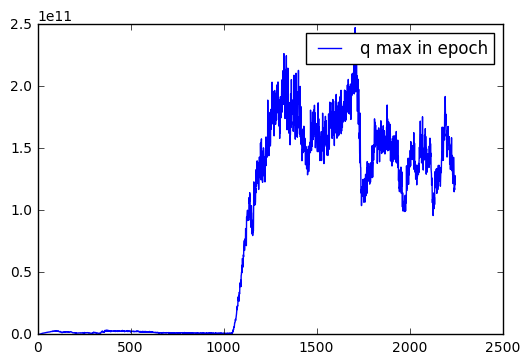

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(qmaxs, label='q max in epoch')
plt.legend()
_ = plt.ylim()

#  ; q max dropped along with epochs

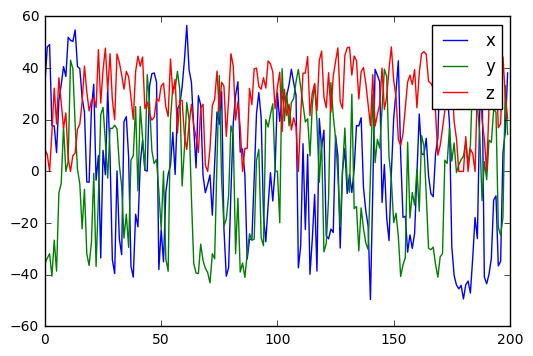

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
xs, ys, zs, _, _, _ = zip(*xyzs)
plt.plot(xs[2000:2200], label='x')
plt.plot(ys[2000:2200], label='y')
plt.plot(zs[2000:2200], label='z')
plt.legend()
_ = plt.ylim()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
my reward is sum of a few factors: 
<br>1. improvement of distance to target -- maybe in future update it to favor movement towards to target
<br>2. no rotation -- sum of eular angles
<br>3. no shifting on x or y coordinates

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- actor critic. (though for z-axis movement, simpler policy search algorithms should work as well)
- max step is 256--while quadcopter can run 500+ steps in late stage; replay buffer is 128K which is big enough to save all episodes; 100~1000 epochs, batch size 32; scale actor output to 500 times bigger; actor learning rate 0.001 and critic learning rate 0.01; gamma is 1; taus are 0.9.
input dim is 12 and output dim is 4; this is why the quadcopter moves around too much. if there is only one output, we actually change the 3-D problem to a 1-D problem.
- two hidden layers: 40 and 30 neurons -- used to be much bigger but didn't see the benefit on a z-axis only training; last layer of actor uses tanh. 

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
- the hardest in the course. in addition to the problem itself, challenge of using keras/tensorflow is big to me too. 
- it is a painful long curve.  real improvements only happened after i focused on reward function.
- not so good, though sometimes the agent did reach close enough (<1 radius) to the target.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- the hardest part may be lack of a great starting point: a well implemented actor critic code that i can trusted, a successful training on another problem so that we can observe the performance curve, a complete document about the env so that i know the range of rotor speed--whether it can be negative? ... etc.  when training didn't improve --which happens so often-- i had *everything* to concern.
- *absolutely*. 